In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from tqdm.notebook import trange, tqdm

In [3]:
%matplotlib notebook
np.set_printoptions(precision=4, linewidth=500, threshold=500, suppress=True)

In [4]:
from numpy import kron, eye as I, exp, trace as tr, diag
from numpy.linalg import inv, eigh

In [5]:
from utils import vec, mat, get_chain_graph, get_random_graph, matrix_derivative_numerical, mat_pow, diagi

In [6]:
import stan

In [7]:
import nest_asyncio
nest_asyncio.apply()

In [8]:
def get_params(T, N, gamma, beta, random_graph=False, seed=True, p=0.5):
    
    if seed:
        np.random.seed(1)
    
    Y = np.random.normal(size=(N, T)) 
    S = np.random.choice([0, 1], p=[1 - p, p], replace=True, size=(N, T))
    S_ = 1 - S
    Y = Y * S

    K = np.exp(-(np.linspace(0, 3, T)[:, None] - np.linspace(0, 3, T)[None, :]) ** 2) + 1e-4 * I(T)
    
    if random_graph:
        _, LT = get_random_graph(T)
        _, LN = get_random_graph(N)
        
    else:
        _, LT = get_chain_graph(T)
        _, LN = get_chain_graph(N)

    lamLT, UT = eigh(LT)
    lamLN, UN = eigh(LN)
    lamK, V = eigh(K)
        
    lamT = exp(-beta * lamLT) ** 2
    lamN = exp(-beta * lamLN) ** 2

    HT = UT @ diag(lamT) @ UT.T
    HN = UN @ diag(lamN) @ UN.T
    
    J = np.outer(lamN, lamT) / (np.outer(lamN, lamT) + gamma)
    G = np.outer(lamN, lamT)
    
    return T, N, gamma, Y, S, S_, lamT, lamN, HT, HN, UT, UN, K, lamK, V, J, G

In [9]:
T, N, gamma, Y, S, S_, lamT, lamN, HT, HN, UT, UN, K, lamK, V, J, G = get_params(T=15, N=10, beta=1, gamma=1.4, random_graph=False)

In [10]:
G

array([[1.    , 0.9163, 0.7076, 0.4658, 0.2662, 0.1353, 0.063 , 0.0278, 0.0121, 0.0053, 0.0025, 0.0013, 0.0007, 0.0005, 0.0004],
       [0.8222, 0.7534, 0.5818, 0.383 , 0.2189, 0.1113, 0.0518, 0.0229, 0.0099, 0.0044, 0.002 , 0.001 , 0.0006, 0.0004, 0.0003],
       [0.4658, 0.4268, 0.3296, 0.217 , 0.124 , 0.063 , 0.0294, 0.013 , 0.0056, 0.0025, 0.0012, 0.0006, 0.0003, 0.0002, 0.0002],
       [0.1923, 0.1762, 0.1361, 0.0896, 0.0512, 0.026 , 0.0121, 0.0053, 0.0023, 0.001 , 0.0005, 0.0002, 0.0001, 0.0001, 0.0001],
       [0.063 , 0.0578, 0.0446, 0.0294, 0.0168, 0.0085, 0.004 , 0.0018, 0.0008, 0.0003, 0.0002, 0.0001, 0.    , 0.    , 0.    ],
       [0.0183, 0.0168, 0.013 , 0.0085, 0.0049, 0.0025, 0.0012, 0.0005, 0.0002, 0.0001, 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.0053, 0.0049, 0.0038, 0.0025, 0.0014, 0.0007, 0.0003, 0.0001, 0.0001, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.0017, 0.0016, 0.0012, 0.0008, 0.0005, 0.0002, 0.0001, 0.    , 0.    , 0.    , 0.    , 0

In [18]:
graph_code2 = """

data {
  int<lower=1> N;         
  int<lower=1> T;         
  real<lower=0> gamma; 
  
  matrix[N, T] Y;
  matrix<lower=0, upper=1>[N, T] S;
  matrix<lower=0, upper=1>[N, T] G_h;
  matrix[N, N] UN;
  matrix[T, T] UTT;

}


parameters {
  matrix[N, T] Z;
}


model {
  to_vector(Z) ~ normal(0, 1 / sqrt(gamma));
  to_vector(Y) ~ normal(to_vector(S .* (UN * (G_h .* Z) * UTT)), 1);
}

"""

In [19]:
GG = G ** 0.5
GG[0, 0] = 1 - 1e-6

graph_data = {"N": N, 'T': T, 'gamma': gamma, 'Y': Y, 'S': S, 'G_h': GG, 'UN': UN, 'UTT': UT.T}

posterior = stan.build(graph_code2, data=graph_data)


Building: 0.3s
Building: 0.4s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 7.0s
Building: 7.1s
Building: 

In file included from /home/ed/miniconda3/envs/p310/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:7,
                 from /home/ed/.cache/httpstan/4.7.2/models/tdhwq6xt/model_tdhwq6xt.cpp:2:
/home/ed/miniconda3/envs/p310/lib/python3.10/site-packages/httpstan/include/stan/io/dump.hpp: In member function ‘virtual std::vector<std::complex<double> > stan::io::dump::vals_c(const string&) const’:
/home/ed/miniconda3/envs/p310/lib/python3.10/site-packages/httpstan/include/stan/io/dump.hpp:694:52: warning: comparison of integer expressions of different signedness: ‘int’ and ‘std::vector<double, std::allocator<double> >::size_type’ {aka ‘long unsigned int’} [-Wsign-compare]
  694 |       for (comp_iter = 0, real_iter = 0; real_iter < val_r->second.first.size();
      |                                          ~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~
/home/ed/miniconda3/envs/p310/lib/python3.10/site-packages/httpstan/include/stan/io/dump.hpp:707:24: warning: comparison

Building: 16.5s
Building: 16.6s
Building: 16.7s
Building: 16.8s
Building: 16.9s
Building: 17.0s
Building: 17.1s
Building: 17.2s
Building: 17.3s


/home/ed/.cache/httpstan/4.7.2/models/tdhwq6xt/model_tdhwq6xt.cpp: In instantiation of ‘void model_tdhwq6xt_namespace::model_tdhwq6xt::transform_inits_impl(VecVar&, VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_std_vector_t<T>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/ed/.cache/httpstan/4.7.2/models/tdhwq6xt/model_tdhwq6xt.cpp:675:69:   required from here
/home/ed/.cache/httpstan/4.7.2/models/tdhwq6xt/model_tdhwq6xt.cpp:494:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  494 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~


Building: 17.4s
Building: 17.5s
Building: 17.6s
Building: 17.7s
Building: 17.8s
Building: 17.9s
Building: 18.0s
Building: 18.1s
Building: 18.2s
Building: 18.3s
Building: 18.4s
Building: 18.5s
Building: 18.6s
Building: 18.7s
Building: 18.8s
Building: 19.0s
Building: 19.1s
Building: 19.2s
Building: 19.3s
Building: 19.4s
Building: 19.5s
Building: 19.6s
Building: 19.7s
Building: 19.8s
Building: 19.9s
Building: 20.0s
Building: 20.1s
Building: 20.2s
Building: 20.3s
Building: 20.4s
Building: 20.5s
Building: 20.6s
Building: 20.7s
Building: 20.8s
Building: 20.9s
Building: 21.0s
Building: 21.1s
Building: 21.2s
Building: 21.3s
Building: 21.4s
Building: 21.5s
Building: 21.6s
Building: 21.8s
Building: 21.9s
Building: 22.0s
Building: 22.1s
Building: 22.2s
Building: 22.3s
Building: 22.4s
Building: 22.5s


/home/ed/.cache/httpstan/4.7.2/models/tdhwq6xt/model_tdhwq6xt.cpp: In instantiation of ‘void model_tdhwq6xt_namespace::model_tdhwq6xt::write_array_impl(RNG&, VecR&, VecI&, VecVar&, bool, bool, std::ostream*) const [with RNG = boost::random::additive_combine_engine<boost::random::linear_congruential_engine<unsigned int, 40014, 0, 2147483563>, boost::random::linear_congruential_engine<unsigned int, 40692, 0, 2147483399> >; VecR = Eigen::Matrix<double, -1, 1>; VecI = std::vector<int>; VecVar = std::vector<double, std::allocator<double> >; stan::require_vector_like_vt<std::is_floating_point, VecR>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; stan::require_std_vector_vt<std::is_floating_point, VecVar>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/ed/.cache/httpstan/4.7.2/models/tdhwq6xt/model_tdhwq6xt.cpp:606:7:   required from ‘void model_tdhwq6xt_namespace::model_tdhwq6xt::write_array(RNG&, Eigen::Matrix<double, -1, 1>&, Eig

Building: 22.6s
Building: 22.7s
Building: 22.8s
Building: 22.9s
Building: 23.0s
Building: 23.1s
Building: 23.2s
Building: 23.3s
Building: 23.4s


In file included from /home/ed/miniconda3/envs/p310/lib/python3.10/site-packages/httpstan/include/stan/math/prim/err/check_not_nan.hpp:5,
                 from /home/ed/miniconda3/envs/p310/lib/python3.10/site-packages/httpstan/include/stan/math/prim/err/check_2F1_converges.hpp:5,
                 from /home/ed/miniconda3/envs/p310/lib/python3.10/site-packages/httpstan/include/stan/math/prim/err.hpp:4,
                 from /home/ed/miniconda3/envs/p310/lib/python3.10/site-packages/httpstan/include/stan/math/rev/core/profiling.hpp:9,
                 from /home/ed/miniconda3/envs/p310/lib/python3.10/site-packages/httpstan/include/stan/math/rev/core.hpp:53,
                 from /home/ed/miniconda3/envs/p310/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:8,
                 from /home/ed/miniconda3/envs/p310/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/ed/miniconda3/envs/p310/lib/python3.10/site-packages/httpstan/include/st

Building: 23.5s
Building: 23.6s
Building: 23.7s
Building: 23.8s
Building: 23.9s
Building: 24.0s
Building: 24.1s
Building: 24.2s
Building: 24.3s
Building: 24.5s
Building: 24.6s
Building: 24.7s
Building: 24.8s
Building: 24.9s
Building: 25.0s
Building: 25.1s
Building: 25.2s
Building: 25.3s
Building: 25.4s
Building: 25.5s
Building: 25.6s
Building: 25.7s
Building: 25.8s
Building: 25.9s
Building: 26.0s
Building: 26.1s
Building: 26.2s
Building: 26.3s
Building: 26.4s
Building: 26.5s
Building: 26.6s
Building: 26.7s
Building: 26.9s
Building: 27.0s
Building: 27.1s
Building: 27.2s
Building: 27.3s
Building: 27.4s
Building: 27.5s
Building: 27.6s
Building: 27.7s
Building: 27.8s
Building: 27.9s
Building: 28.0s
Building: 28.1s
Building: 28.2s
Building: 28.3s
Building: 28.4s
Building: 28.5s
Building: 28.6s
Building: 28.7s
Building: 28.8s
Building: 28.9s
Building: 29.0s
Building: 29.1s
Building: 29.2s
Building: 29.3s
Building: 29.4s
Building: 29.5s
Building: 29.7s
Building: 29.8s
Building: 29.9s
Building

Building: 49.1s, done.
Messages from stanc:


In [29]:
fit = posterior.sample(num_chains=4, num_samples=800)

Sampling:   0%
Sampling:   3% (200/7200)
Sampling:   7% (500/7200)
Sampling:  17% (1200/7200)
Sampling:  42% (3000/7200)
Sampling:  64% (4600/7200)
Sampling:  85% (6100/7200)
Sampling: 100% (7200/7200)
Sampling: 100% (7200/7200), done.
Messages received during sampling:
  Gradient evaluation took 8.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.87 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.74 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.74 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000106 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.06 seconds.
  Adjust your expectations accordingly!


In [30]:
fit['Z'].shape

(10, 15, 3200)

In [23]:
Sigma_true_inv = diag(vec(S)) + gamma * kron(inv(HT), inv(HN))
Sigma_true = inv(Sigma_true_inv)
Omega_true = mat(diag(Sigma_true), like=J)

In [33]:
Fs = np.array([(UN @ (G ** 0.5 * fit['Z'][:, :, i]) @ UT.T) for i in range(800)])

<IPython.core.display.Javascript object>


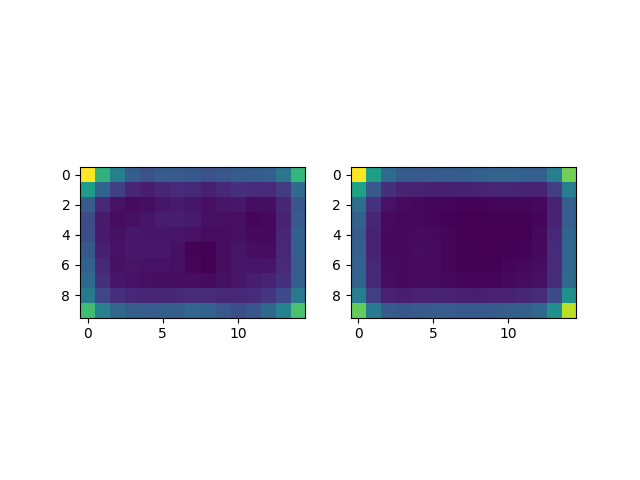

In [35]:
fig, ax = plt.subplots(ncols=2)

ax[0].imshow(np.var(Fs, axis=0))
ax[1].imshow(Omega_true)

In [11]:
graph_code = """

functions {
  real graph_signal_lpdf(matrix Z, matrix Y, matrix S, matrix G_h, matrix UN, matrix UTT, real gamma, int N, int T) {
    matrix[N, T] F_ = Y - S .* (UN * (G_h .* Z) * UTT);
    return -0.5 * (sum(F_ .* F_) + gamma * sum(Z .* Z));
  }
}


data {
  int<lower=1> N;         
  int<lower=1> T;         
  real<lower=0> gamma; 
  
  matrix[N, T] Y;
  matrix<lower=0, upper=1>[N, T] S;
  matrix<lower=0, upper=1>[N, T] G_h;
  matrix[N, N] UN;
  matrix[T, T] UTT;

}


parameters {
  matrix[N, T] Z;
}


model {
  target += graph_signal_lpdf(Z | Y, S, G_h, UN, UTT, gamma, N, T);       // prior log-density
}

"""

# graph_data = {"N": N, 'T': T, 'gamma': gamma, 'Y': Y, 'S': S, 'G_h': G ** 0.5, 'UN': UN, 'UTT': UT.T}

# posterior = stan.build(graph_code, data=graph_data)
# fit = posterior.sample(num_chains=4, num_samples=1000)


In [36]:
from PIL import Image

im = Image.open("pic.jpg").convert('L')

In [37]:
Y_clean = np.array(im)

N, T = Y_clean.shape

T, N, gamma, Y, S, S_, lamT, lamN, HT, HN, UT, UN, K, lamK, V, J, G = get_params(T=T, N=N, gamma=5, beta=5, random_graph=False)

S = np.round(UN @ (G * (UN.T @ S @ UT)) @ UT.T + 2e-2)
S_ = 1 - S

Y_clean = (Y_clean - Y_clean.mean()) / Y_clean.std()


Y_noisy = Y_clean + np.random.normal(size=Y_clean.shape)


Y_partial = Y_noisy.copy()
Y_partial[S_.astype(bool)] = np.nan


Y = Y_noisy.copy()
Y[S_.astype(bool)] = 0

# F, its = get_sol(Y, S)


In [38]:
GG = G ** 0.5
GG[0, 0] = 1 - 1e-6

graph_data = {"N": N, 'T': T, 'gamma': gamma, 'Y': Y, 'S': S, 'G_h': GG, 'UN': UN, 'UTT': UT.T}

posterior = stan.build(graph_code2, data=graph_data)


Building: found in cache, done.
Messages from stanc:


In [39]:
fit = posterior.sample(num_chains=4, num_samples=200)

Sampling:   0%
Sampling:   0% (1/4800)
Sampling:   0% (2/4800)
Sampling:   0% (3/4800)
Sampling:   0% (4/4800)


In [44]:
T, N, gamma, Y, S, S_, lamT, lamN, HT, HN, UT, UN, K, lamK, V, J, G = get_params(T=15, N=10, beta=1, gamma=1.4, random_graph=False)

In [76]:
def fz(Z):
    F = UN @ (G ** 0.5 * Z) @ UT.T
    return tr((Y - S * F).T @ (Y - S * F)) + gamma * tr(Z.T @ Z)

def fq(Q):
    F = UN @ Q @ UT.T
    return tr((Y - S * F).T @ (Y - S * F)) + gamma * tr(Q.T @ (G ** -1 * Q))

def matrix_derivative_numerical(f, W):
    
    out = np.zeros_like(W)
    dx = 0.001
    
    T, M = W.shape
    
    for i in range(T):
        for j in range(M):
            
            W_ = W.copy()
            _W = W.copy()
            W_[i, j] += dx / 2
            _W[i, j] -= dx / 2
            out[i, j] = (f(W_) - f(_W)) / dx
    
    return out


def derivz(Z):
    return 2 * gamma * Z - 2 * UN.T @ Y @ UT * G ** 0.5 + 2 * (UN.T @ (S * (UN @ (G ** 0.5 * Z) @ UT.T)) @ UT) * G ** 0.5

def derivq(Q):
    return 2 * G ** -1 * Q - 2 * UN.T @ (S * Y) @ UT + 2 * UN.T @ (S * (UN @ Q @ UT.T)) @ UT

In [77]:
matrix_derivative_numerical(fq, Y)

array([[       0.3307,       -0.3223,       -0.5376,       -7.2048,        8.8829,      -46.4487,        2.2593,      -78.4015,        2.4048,        0.5132,       -0.0068,    -4578.3876,        1.8   ,    -2268.7342,     8672.1615],
       [      -0.8951,        1.5788,        0.2526,       -0.4081,        9.5519,       -0.3672,       64.4751,      111.6269,      141.468 ,      576.5339,     -940.0919,       -0.3793,    -4424.3235,    -1926.0803,        5.8603],
       [      -0.0022,       -4.0415,        0.456 ,      -12.8625,       -2.6034,        0.583 ,       -1.5786,       50.8153,      827.2043,       -1.7707,     -464.7762,    -4231.6242,        0.1503,       -1.1231,      833.7915],
       [     -13.703 ,       -1.2919,       45.3149,        0.0104,       35.6299,       31.3638,      -81.1088,     -599.2522,     -422.2851,        2.2082,     3444.5166,     9693.8845,    18828.9669,     8771.8916,    35210.1495],
       [     -34.5901,        3.089 ,       33.5144,       -0.16

In [78]:
derivq(Y)

array([[       0.3307,       -0.3223,        0.0595,       -5.3621,        6.2822,      -32.8438,        2.2593,      -56.5145,        2.4048,        0.5132,       -0.0068,    -3270.5202,        1.8   ,    -1620.6199,     6194.6876],
       [      -0.8951,        1.5788,        0.2526,       -0.4081,        7.4217,       -0.3672,       46.8076,       80.0974,      100.9165,      411.8071,     -671.7035,       -0.3793,    -3159.9751,    -1376.2409,        5.8603],
       [      -0.0022,       -3.2979,        0.456 ,       -9.7465,       -2.6034,        0.7437,       -1.5786,       36.3462,      590.7865,       -1.7707,     -331.8662,    -3021.9462,        0.1503,       -1.1231,      595.4576],
       [     -11.0526,       -1.2919,       32.9657,        0.0104,       25.983 ,       22.1352,      -57.8604,     -428.3936,     -301.7276,        2.2082,     2459.8109,     6923.688 ,    13449.2175,     6265.2733,    25150.3984],
       [     -25.017 ,        3.089 ,       24.3163,       -0.16